# WL Shear correlation functions $\xi_\pm(\theta)$ (whole pipeline)
#### from Takahashi simulations (maps as *.fits*)

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import treecorr,time
# import pickle
import os
print(os.getcwd())
print("numpy version:", np.__version__ )

/global/u2/r/rafamm97
numpy version: 1.16.2


## Reading *.fits* maps

Read a healpix map from a fits file. Partial-sky files, if properly identified, are expanded to full size and filled with UNSEEN

# Defining angular coordinates

#### Choosing the angular parameter $N_{side}$ as $2^{12}$ and defining the angular coordinates $\theta, \phi$ with the healpix function **pix2ang** which documentation is

- healpy.pixelfunc.**pix2ang**(*nside, ipix*)
- **Returns the coord.  theta, phi (floats) in radians corresponding to ipix, scalar or array-like**

    **Parameters**
    
    nside: a healpix resolution parameter that must be a power of 2 ($<2^{30}$)
    
    ipix: Pixel indices

## Reading *.fits* maps

Read a healpix map from a fits file. Partial-sky files, if properly identified, are expanded to full size and filled with UNSEEN

In [2]:
def function1(num_realization):
    gamma1=hp.fitsfunc.read_map(filename = 'output_g1_' + str(num_realization) +'.fits')
    gamma2=hp.fitsfunc.read_map(filename = 'output_g2_' + str(num_realization) +'.fits')

    NSIDE = 4096   # angular resolution size

    tht, phi = hp.pix2ang(nside = NSIDE, ipix = range(hp.nside2npix(NSIDE)))# in radians
    # << hp.nside2npix >> gives the number of pixels for the given nside.
    
    if num_realization == 1:
        print(len(tht))  # number of values/elements in theta array
    
    # Defining limit values of the angle in arcmin and its conversion to rad
    minArcmin = 5.
    maxArcmin = 200.

    minRad = minArcmin*np.pi/60/180  # converting values to radian
    maxRad = maxArcmin*np.pi/60/180
    
    if num_realization == 1:
        print("Chosen angular limit values as: \n \n minRad={:.5}, maxRad={:.5}".format(minRad,maxRad))

    nInputSize = len(tht)       # defining size
    nSample = int(nInputSize/2) # max is len(tht)    # two #theta for one sample
    
    if num_realization == 1:
        print("Taking", nSample, "points out of", nInputSize )

    nDec, nRac, nG1, nG2 = [], [], [], []   # empty arrays to be filled w/ the Declin., right ascension and shear1,2

    #rng = np.random.default_rng(2021)
    #nii = rng.choice(len(tht), size=nSample, replace=False)

    np.random.seed(2022)  # taking initial conditions in order to make random realizations 'reproducible'

    # Choosin randomly unrepeated terms between (0 - nInputSize)
    nii = np.random.choice(nInputSize, nSample, replace=False) # Which has the syntaxis: random.choice(a, size=None, replace=True)
                                                             # where a random sample is generated as np.arange(0,a)

    for ii in nii: 
        nDec.append(tht[ii])   # declination
        nRac.append(phi[ii])   # right ascension
        nG1.append(gamma1[ii]) # shear 1
        nG2.append(gamma2[ii]) # shear 2

    del tht, phi, gamma1, gamma2  # ereasing data (to reset)
    return  nDec, nRac, nG1, nG2, nSample

# *TreeCorr* implementation

In [3]:
def function2(nDec,nRac,nG1,nG2,nSample,num_realization):
    minArcmin = 5.
    maxArcmin = 200.

    minRad = minArcmin*np.pi/60/180  # converting values to radian
    maxRad = maxArcmin*np.pi/60/180
    
    # Now using T r e e C o r r package to compute CF
    
    # building catalogue passing arrays for each piece of information
    cat = treecorr.Catalog(\
        ra = nRac, dec=nDec, g1=nG1, g2=nG2, ra_units ="rad", dec_units ="rad") # catalogue defined

    #cat = treecorr.Catalog(\
    #    ra=phi,dec=tht,g1=gamma1,g2=gamma2,ra_units="rad",dec_units="rad") # same with spherical coord. instead of celestial

    # Now creating the GG correlation (shear - shear corr.)
    GG = treecorr.GGCorrelation(min_sep=minRad, max_sep=maxRad, verbose=2, nbins=20)
                     # where: min_sep - minimum separation being considered
                     #        max_sep - analogous
    
    times = {}   # dictionary
    
    t1 = time.perf_counter()  # time in fractional seconds of a performance counter (***highest available resolution for short duration***)
    GG.process(cat)
    times[nSample] = round(time.perf_counter()-t1, ndigits = 4)
    if num_realization ==1:
        print(times)
    return GG

## Outputs

In [4]:
def save_output(outputfilename, GG):
    salida = np.zeros((len(GG.xim),4))   # array of zeros to be filled w/ 
    #print(salida)              # Prints 
    thtArr=np.array(GG.meanr)*60*180/np.pi
    for ii in range(len(GG.xim)):
        salida[ii,0] = thtArr[ii]
        salida[ii,1] = GG.xip[ii] # 'plus' component
        salida[ii,2] = GG.xim[ii] # 'minus' component
        salida[ii,3] = GG.npairs[ii]

    #print(salida) 

    #outputfilename='xi_pm.txt'

    header = "# 1.meanr  2.xi_plus  3.xi_minus  4.npairs"

    with open(outputfilename, 'a') as f:
        f.write(header + "\n")
        np.savetxt(f, salida)
        f.close

# Execution
Running modules (function) to create outputs with every single file

In [5]:
start_time = time.time() # Computing time

##### ******* Here you have to choose the total of realizations you want (range) *******

for i in range(11,16): # from i=1 until i=109 for the 108 realizations in total (JUST ONE z each)
    if i < 10:
        outputfilename ='xi_pm_'+str(i)+".txt"
        nDec, nRac, nG1,nG2, nS = function1(i)
        GG = function2(nDec,nRac,nG1,nG2,nS,i)
        #create_output(i, outputfilename)
        save_output(outputfilename, GG)
    if 10 <= i <= 99:
        outputfilename ='xi_pm_'+str(i)+".txt"
        nDec, nRac, nG1,nG2, nS = function1(i)
        GG = function2(nDec,nRac,nG1,nG2,nS,i)
        # create_output(i, outputfilename)
        save_output(outputfilename, GG)

end_time = time.time()
print('Time:', end_time - start_time, 's.')    
print('output file will be xi_pm_i.txt,\n where i is the realization number from 0 to 107')

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


nbins = 20, min,max sep = 0.00145444..0.0581776, bin_size = 0.184444
varg = 0.000000: sig_sn (per component) = 0.000580
Starting process GG auto-correlations
Using 64 threads.
Building GField
Starting 85 jobs.


NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


nbins = 20, min,max sep = 0.00145444..0.0581776, bin_size = 0.184444
varg = 0.000000: sig_sn (per component) = 0.000565
Starting process GG auto-correlations
Using 64 threads.
Building GField
Starting 85 jobs.


NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


nbins = 20, min,max sep = 0.00145444..0.0581776, bin_size = 0.184444
varg = 0.000000: sig_sn (per component) = 0.000556
Starting process GG auto-correlations
Using 64 threads.
Building GField
Starting 85 jobs.


NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


nbins = 20, min,max sep = 0.00145444..0.0581776, bin_size = 0.184444
varg = 0.000000: sig_sn (per component) = 0.000571
Starting process GG auto-correlations
Using 64 threads.
Building GField
Starting 85 jobs.


NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


nbins = 20, min,max sep = 0.00145444..0.0581776, bin_size = 0.184444
varg = 0.000000: sig_sn (per component) = 0.000558
Starting process GG auto-correlations
Using 64 threads.
Building GField
Starting 85 jobs.


Time: 3118.0456602573395 s.
output file will be xi_pm_i.txt,
 where i is the realization number from 0 to 107


# Plots ($\theta \xi_\pm(\theta)$)

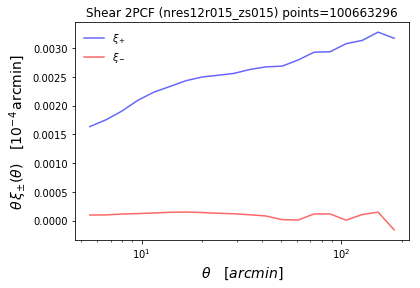

In [8]:
thtArr=np.array(GG.meanr)*60*180/np.pi

#plt.figure(figsize=(10,8))
fig = plt.figure();
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('equal')
ax1.set_xscale('log')
ax1.plot(thtArr,thtArr*GG.xip*10**4,linestyle="-",c="b",alpha=.6,label="$\\xi_+$")
ax1.plot(thtArr,thtArr*GG.xim*10**4,linestyle="-",c="r",alpha=.6,label="$\\xi_-$")
ax1.legend(frameon=False)
ax1.set_ylabel(r"$\theta\, \xi_{\pm}(\theta) \quad [10^{-4} \, \rm{arcmin}]$", fontsize=14)
ax1.set_xlabel(r"$\theta  \quad [arcmin]$", fontsize=14);
plt.title(r'Last shear 2PCF (nres12r015_zs015) points=100663296') # assuming the last one, in our case just 15 realiz. were taken

#plt.show();
fig.savefig('nres12r015_zs015.png') #,dpi=150)

# Covariance matrix

This part of the nb computes the correlation and covariance of a data set o N files

******* Putted in another nb *******